In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path

2022-06-08 14:12:25.148992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 14:12:25.149054: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# define global constants

# points towards the data with the magic wand held idle
IDLE_PATH = Path("data/raw_data/idle.csv")
# points towards the data with the magic wand being rotated
CIRCLE_PATH = Path("data/raw_data/circle.csv")
# the maximum value that the MPU sensor can output
MPU_MAX_OUT = 32768
# use 10% of data for testing
TEST_FRAC = 0.1
# use 10% of data for validation 
VAL_FRAC = 0.1
# the number of consecutively recorded data points that are assembled to an image
TIME_FRAME = 128
# the number of classes
NUM_CLASSES = 2
# data dimension associated with a single data point in time
# the MPU records x, y and z axis acceleration
SENSOR_DIM = 3
# output paths to which the processed output is written
TRAIN_Y_PATH = Path("data/train_y.csv")
VAL_Y_PATH = Path("data/val_y.csv")
TEST_Y_PATH = Path("data/test_y.csv")
TRAIN_X_PATH = Path("data/train_x.csv")
VAL_X_PATH = Path("data/val_x.csv")
TEST_X_PATH = Path("data/test_x.csv")

In [3]:
def num_images_before_reshape(data):
    """calculate number of images per set."""
    return data.shape[0]//TIME_FRAME

def motion_to_image(data):
    """convert a time series to a motion image."""
    return data.reshape(num_images_before_reshape(data), TIME_FRAME, SENSOR_DIM)

def load_data():
    """load the data and apply final pre-processing"""
    # train data
    train_X = pd.read_csv(TRAIN_X_PATH, header=None)
    train_X = train_X.to_numpy()
    train_X = motion_to_image(train_X)
    train_X = np.expand_dims(train_X, axis=3)
    # train labels
    train_y = pd.read_csv(TRAIN_Y_PATH, header=None).to_numpy()

    # validation data
    val_X = pd.read_csv(VAL_X_PATH, header=None)
    val_X = val_X.to_numpy()
    val_X = motion_to_image(val_X)
    val_X = np.expand_dims(val_X, axis=3)
    # validation labels
    val_y = pd.read_csv(VAL_Y_PATH, header=None).to_numpy()
    
    # test data 
    test_X = pd.read_csv(TEST_X_PATH, header=None)
    test_X = test_X.to_numpy()
    test_X = motion_to_image(test_X)
    test_X = np.expand_dims(test_X, axis=3)
    # test labels
    test_y = pd.read_csv(TEST_Y_PATH, header=None).to_numpy()
    return train_X, train_y, val_X, val_y, test_X, test_y

train_X, train_y, val_X, val_y, test_X, test_y = load_data()

In [4]:
# model design with convolutional layers
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(128,3,1)),
    tf.keras.layers.Conv2D(32, (4,3), padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D((3,3)),
    tf.keras.layers.Conv2D(16, (4,1), padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(8, (4,1), padding="same", activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# assemble the model
model.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics=["accuracy"])

2022-06-08 14:13:25.411630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 14:13:25.412287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 14:13:25.412489: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-06-08 14:13:25.412584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-06-08 14:13:25.412664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [11]:
# start training
history = model.fit(train_X, train_y, epochs=10, batch_size=128, validation_data=(val_X, val_y))

def next_free_name():
    """Get a free name to save a model."""
    for i in range(100):
        name = Path("models")/f"ver{i}"
        if not name.exists(): return name
    else: return Path("models/ver0")

model.save(next_free_name())

Epoch 1/10
13/13 [==============================] - 0s 15ms/step - loss: 0.6932 - accuracy: 0.4875 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
13/13 [==============================] - 0s 15ms/step - loss: 0.6932 - accuracy: 0.4762 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
13/13 [==============================] - 0s 15ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.4837 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
13/13 [==============================] - 0s 15ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
13/13 [==============================] - 0s 15ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 8/10
13

INFO:tensorflow:Assets written to: models/ver0/assets


INFO:tensorflow:Assets written to: models/ver0/assets


In [7]:
# inspect predictions on the test set manually
model.predict(test_X)

7/7 [==============================] - 0s 3ms/step


array([[0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],
       [0.5000108],


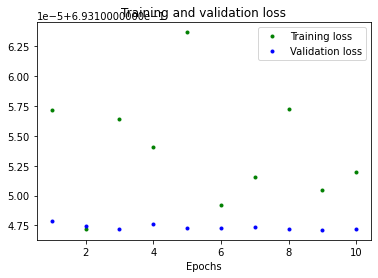

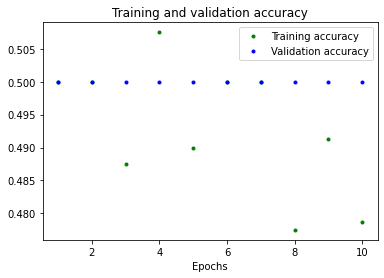

In [8]:
def plot_training_loss():
    """plot the training and validation loss."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'g.', label='Training loss')
    plt.plot(epochs, val_loss, 'b.', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

def plot_training_accuracy():
    """plot the training and validation accuracy."""
    loss = history.history['accuracy']
    val_loss = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'g.', label='Training accuracy')
    plt.plot(epochs, val_loss, 'b.', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

plot_training_loss()
plot_training_accuracy()